In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
model_type = "DPT_Large"
midas = torch.hub.load("intel-isl/MiDas", model_type)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()
midas_transforms = torch.hub.load("intel-isl/MiDas", "transforms")
if (model_type=="DPT_Large" or model_type == "DPT_Hybrid"):
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

In [ ]:
def generate_depth_map(input_img):
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    # Apply input transforms
    input_batch = transform(input_img).to(device)
    # Prediction and resize to original resolution
    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=input_img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth_map = prediction.cpu().numpy()
    depth_map = cv2.normalize(depth_map, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    depth_map = (depth_map*255).astype(np.uint8)
    depth_map = cv2.applyColorMap(depth_map , cv2.COLORMAP_MAGMA)
    return depth_map

def generate_rgbd(input_img, depth_map):
    color_raw = o3d.geometry.Image(np.asarray(input_img))
    depth_raw = o3d.geometry.Image(np.asanyarray(depth_map))
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color_raw, depth_raw, convert_rgb_to_intensity=False)
    return rgbd_image

def generate_point_cloud(rgbd_image, camera_intrinsic_o3d):
    # Create the point cloud from images and camera intrisic parameters
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic_o3d)
    # Flip it, otherwise the pointcloud will be upside down
    pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    return pcd

def invert_depth_map(depth_map):
    return 255 - depth_map

In [ ]:
img1 = cv2.imread('my_data/992326147944002.jpg')
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.imread('my_data/992328148154819.jpg')
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(6, 6))
plt.subplot(121)
plt.imshow(img1)
plt.axis('off')
plt.subplot(122)
plt.imshow(img2)
plt.axis('off')
plt.show()

In [ ]:
img1_depth_map = generate_depth_map(img1)
img2_depth_map = generate_depth_map(img2)
plt.figure(figsize=(6, 6))
plt.subplot(121)
plt.imshow(img1_depth_map)
plt.axis('off')
plt.subplot(122)
plt.imshow(img2_depth_map)
plt.axis('off')
plt.show()

In [ ]:
inv_img1_depth_map = invert_depth_map(img1_depth_map)
inv_img2_depth_map = invert_depth_map(img2_depth_map)
plt.figure(figsize=(6, 6))
plt.subplot(121)
plt.imshow(inv_img1_depth_map)
plt.axis('off')
plt.subplot(122)
plt.imshow(inv_img2_depth_map)
plt.axis('off')
plt.show()

In [ ]:
rgbd_img1 = generate_rgbd(img1, inv_img1_depth_map)
rgbd_img2 = generate_rgbd(img2, inv_img2_depth_map)
print(rgbd_img1, rgbd_img2)

In [ ]:
height, width, _ = img1.shape
height, width


In [ ]:
fx = 2.9545e+03
fy = 2.9621e+03
cx = 1.5024e+03
cy = 2.0827e+03

In [ ]:
camera_intrinsic_o3d = o3d.camera.PinholeCameraIntrinsic(width, height, fx,fy, cx, cy)

In [ ]:
pcd1 = generate_point_cloud(rgbd_img1, camera_intrinsic_o3d)
pcd2 = generate_point_cloud(rgbd_img2, camera_intrinsic_o3d)

In [ ]:
o3d.visualization.draw_geometries([pcd1])

In [ ]:
o3d.visualization.draw_geometries([pcd2])

In [ ]:
# Detecting Keypoints
orb = cv2.ORB_create()
Kp1, des1 = orb.detectAndCompute(img1, None)
Kp2, des2 = orb.detectAndCompute(img2, None)
# visualizing the keypoints
img1ORB = cv2.drawKeypoints(img1, Kp1, None,
                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2ORB = cv2.drawKeypoints(img2, Kp2, None,
                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.imshow(img1ORB)
plt.axis('off')
plt.subplot(122)
plt.imshow(img2ORB)
plt.axis('off')
plt.show()

In [ ]:
Kp1_np = np.array([k.pt for k in Kp1])
Kp2_np = np.array([k.pt for k in Kp2])
Kp1_np.shape

In [ ]:
Kp1_img = np.ones((height, width, 3), dtype=np.uint8)*255
dot_size = 15
for point in Kp1_np:
    col, row = point
    col = int(col)
    row = int(row)
    Kp1_img[row - dot_size // 2:row + dot_size // 2, col - dot_size // 2:col + dot_size // 2, :] = [0, 0, 255]
plt.imshow(Kp1_img)
plt.axis('off')
plt.show()

In [ ]:
Kp1_3D = []
# for Kp, depth in zip(Kp1_np, Kp1_depth):
for Kp in Kp1_np:
    u, v = Kp
    depth = np.mean(img1_depth_map[int(v), int(u), :]) / 100
    x = (u - cx) * depth / fx
    y = (v - cy) * depth / fy
    z = depth
    Kp1_3D.append((x, y, z))

Kp1_pcd = o3d.geometry.PointCloud()
Kp1_pcd.points = o3d.utility.Vector3dVector(Kp1_3D)
Kp1_pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
# visualization
o3d.visualization.draw_geometries([Kp1_pcd])

In [ ]:
min_depth = 1e9
max_depth = 0
for Kp in Kp1_np:
    u, v = Kp
    min_depth = min(min_depth, np.mean(img1_depth_map[int(v), int(u), :]))
    max_depth = max(max_depth, np.mean(img1_depth_map[int(v), int(u), :]))
min_depth, max_depth

In [5]:
from MahonyAHRS import MahonyAHRS
from quaternion_operations import quatern2euler, quaternConj, quatern2rotMat
from scipy.signal import butter, filtfilt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
accel = pd.read_csv('my_data/VID_20240110_143256accel.csv').to_numpy()
gyro = pd.read_csv('my_data/VID_20240110_143256gyro.csv').to_numpy()
time = pd.read_csv('my_data/VID_20240110_143256_imu_timestamps.csv').to_numpy()
len(accel), len(gyro), len(time)

(3373, 3371, 3373)

In [7]:
accel = accel[:-2, :]
time = time[:-2, :]
len(accel), len(time)

(3371, 3371)

In [8]:
np.where(abs(time - 992326147944002) < 1e6)

(array([1623], dtype=int64), array([0], dtype=int64))

In [9]:
np.where(abs(time - 992328148154819) < 1e6)

(array([2428], dtype=int64), array([0], dtype=int64))

In [10]:
init_time = np.copy(time[0])
for t in range(len(time)):
    time[t] = time[t] - init_time

In [11]:
time = time * 1e-9

In [12]:
time[-1]

array([8.3753949])

In [13]:
sample_period = 0

for t in range(1, len(time)):
    sample_period += time[t] - time[t - 1]

sample_period /= len(time)

sample_period

array([0.00248454])

In [14]:
time[1623], time[2428] # t1 = 4s and t2 = 6s

(array([4.03359743]), array([6.03424075]))

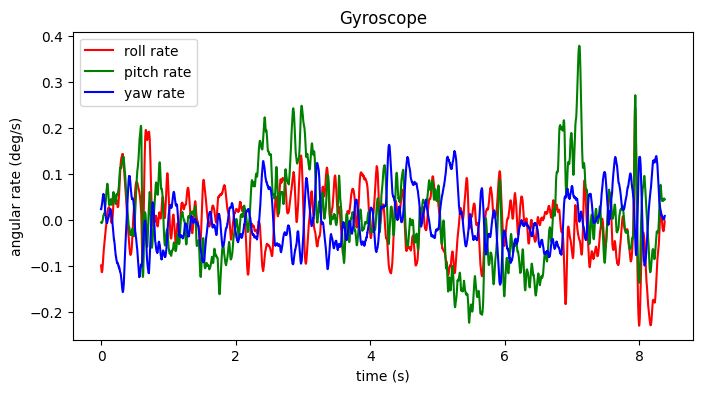

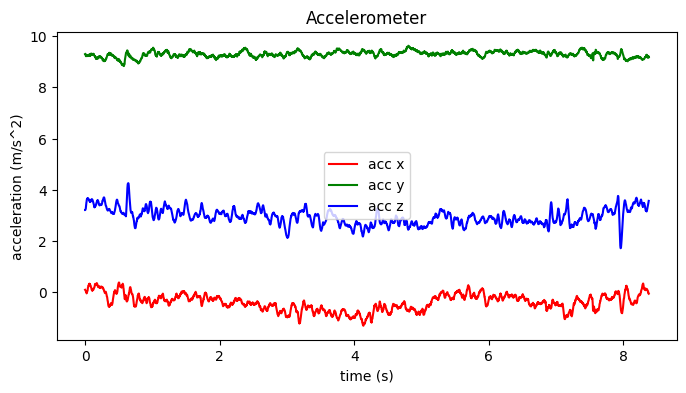

In [15]:
# Data plotting
# for gyro
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, gyro[:, 0], 'r', label="roll rate")
ax.plot(time, gyro[:, 1], 'g', label="pitch rate")
ax.plot(time, gyro[:, 2], 'b', label="yaw rate")
ax.set_title("Gyroscope")
ax.set_xlabel('time (s)')
ax.set_ylabel("angular rate (deg/s)")
ax.legend()
# for acc
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, accel[:, 0], 'r', label="acc x")
ax.plot(time, accel[:, 1], 'g', label="acc y")
ax.plot(time, accel[:, 2], 'b', label="acc z")
ax.set_title("Accelerometer")
ax.set_xlabel('time (s)')
ax.set_ylabel("acceleration (m/s^2)")
ax.legend()

plt.show() ## to much vigorous or abrupt motion

In [16]:
accX, accY, accZ = accel[:, 0], accel[:, 1], accel[:, 2]
gyroX, gyroY, gyroZ = gyro[:, 0], gyro[:, 1], gyro[:, 2]

In [17]:
## compute accel magnitude
acc_mag = np.sqrt(accX*accX + accY*accY + accZ*accZ)
## HP filter to accel data
filtCutOff = 0.0001
[b, a] = butter(1, (2*filtCutOff)/(1/sample_period), 'high')
acc_magFilt = filtfilt(b, a, acc_mag)
## compute abs value
acc_magFilt = np.abs(acc_magFilt)
## LP filter accel data
filtCutOff = 5
[b, a] = butter(1, (2*filtCutOff)/(1/sample_period), 'high')
acc_magFilt = filtfilt(b, a, acc_mag)
## threshold detection
stationary = acc_magFilt < 0.055

In [18]:
AHRS = MahonyAHRS(SamplePeriod=sample_period, Kp=1, Ki=1e-4)
R = np.zeros(shape=(3, 3, len(time)))
quaternion = np.zeros((len(time), 4))

In [19]:
# initial convergance
initPeriod = 2
indexSel = np.arange(0, np.argmax(time > time[0] + initPeriod) + 1)
for i in range(2000):
    AHRS.UpdateIMU(np.array([0, 0, 0]), np.array([np.mean(
        accel[indexSel, 0]), np.mean(accel[indexSel, 1]), np.mean(accel[indexSel, 2])]))

In [20]:
gyro_copy = np.copy(gyro)
accel_copy = np.copy(accel)
for t in range(len(time)):
    if (stationary[t]):
        AHRS.Kp = 0
    else:
        AHRS.Kp = 0.5
    AHRS.UpdateIMU(gyro_copy[t], accel_copy[t])
    quaternion[t] = AHRS.Quaternion
    R[:, :, t] = quatern2rotMat(AHRS.Quaternion).T

In [21]:
quaternConj(quaternion).T.shape

(4, 3371)

(3371, 3)


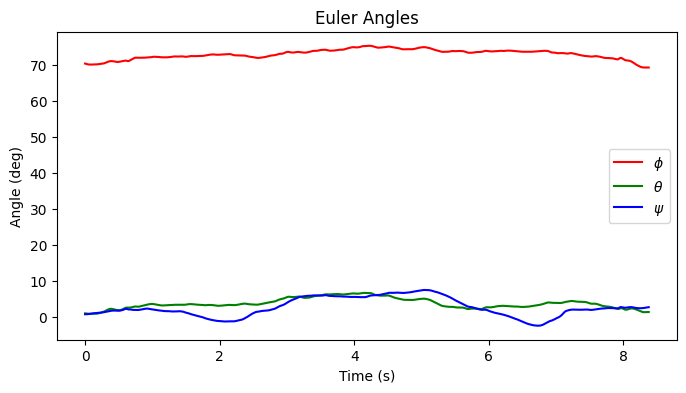

In [22]:
euler = (quatern2euler(quaternConj(quaternion)) * (180 / np.pi))
print(euler.shape)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, euler[:, 0], 'r', label=r'$\phi$')
ax.plot(time, euler[:, 1], 'g', label=r'$\theta$')
ax.plot(time, euler[:, 2], 'b', label=r'$\psi$')
ax.set_title('Euler Angles')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Angle (deg)')
ax.legend()

plt.show()

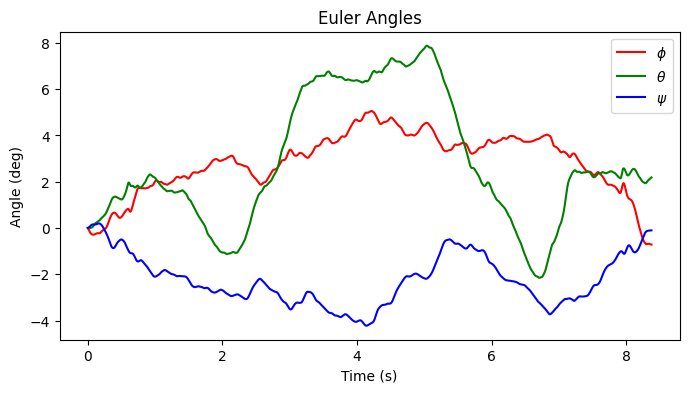

In [23]:
euler_angles = np.zeros_like(gyro)
for t in range(1, len(time)):
    euler_angles[t] = euler_angles[t - 1] + gyro[t] * (time[t] - time[t - 1])
euler_angles = np.rad2deg(euler_angles)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, euler_angles[:, 0], 'r', label=r'$\phi$')
ax.plot(time, euler_angles[:, 1], 'g', label=r'$\theta$')
ax.plot(time, euler_angles[:, 2], 'b', label=r'$\psi$')
ax.set_title('Euler Angles')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Angle (deg)')
ax.legend()

plt.show()

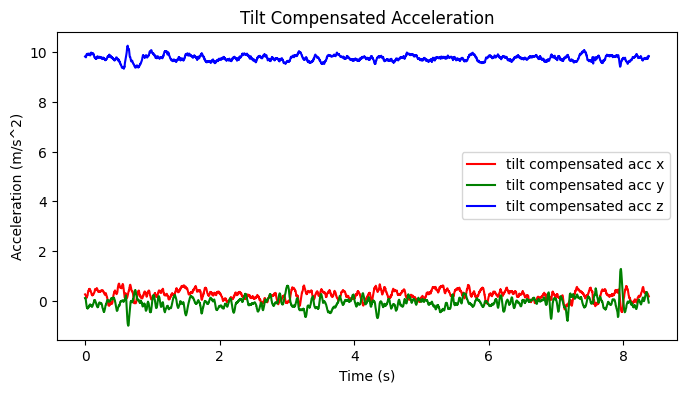

In [24]:
# # calculating tilt-compensated accelerometer
tc_Acc = np.zeros_like(accel)
for t in range(len(time)):
    tc_Acc[t] = np.dot(R[:, :, t], accel[t].T)
# from quaternion_operations import quaternRotate
# tc_Acc = quaternRotate(accel, quaternConj(quaternion))
# plotting tilt-compensated acceleration
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, tc_Acc[:, 0], 'r', label='tilt compensated acc x')
ax.plot(time, tc_Acc[:, 1], 'g', label='tilt compensated acc y')
ax.plot(time, tc_Acc[:, 2], 'b', label='tilt compensated acc z')
ax.set_title('Tilt Compensated Acceleration')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Acceleration (m/s^2)')
ax.legend()

plt.show()

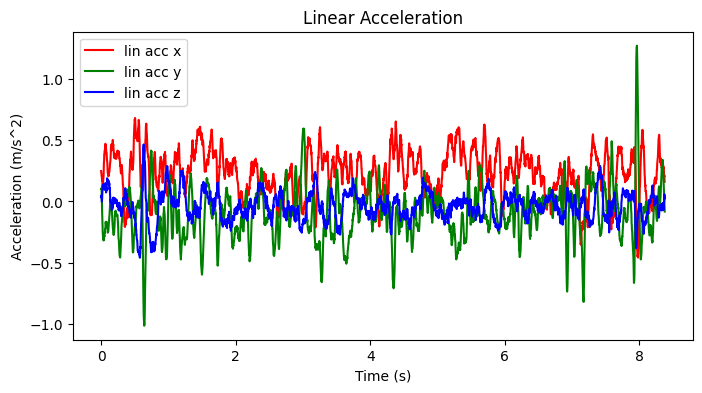

In [25]:
# calculate linear acceleration and convert them into m/s^2
lin_Acc = tc_Acc - np.array([0, 0, 9.8])
# plotting linear acceleration
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, lin_Acc[:, 0], 'r', label='lin acc x')
ax.plot(time, lin_Acc[:, 1], 'g', label='lin acc y')
ax.plot(time, lin_Acc[:, 2], 'b', label='lin acc z')
ax.set_title('Linear Acceleration')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Acceleration (m/s^2)')
ax.legend()

plt.show()

In [26]:
## finding when translational_accel magnitude is less than threshold --> will be considered to be as stationary
t_ax = lin_Acc[:, 0]
t_ay = lin_Acc[:, 1]
t_az = lin_Acc[:, 2]
translational_accel_mag = np.sqrt(t_ax*t_ax + t_ay*t_ay + t_az*t_az)
t_stationary = translational_accel_mag < 0.25 ## translationaly stationary

In [27]:
np.max(translational_accel_mag), np.min(translational_accel_mag)

(1.3449517746605493, 0.020620253627067372)

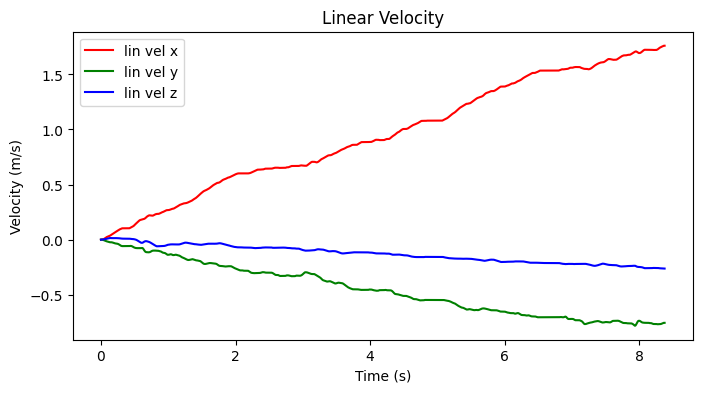

In [28]:
# calculate linear velocity (integrating acceleration)
lin_Vel = np.zeros_like(lin_Acc)
for t in range(1, len(time)):
    if (t_stationary[t]):
        lin_Vel[t] = lin_Vel[t - 1]
    else:
        lin_Vel[t] = lin_Vel[t - 1] + lin_Acc[t] * (time[t] - time[t - 1])
# plotting liear velocity
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, lin_Vel[:, 0], 'r', label='lin vel x')
ax.plot(time, lin_Vel[:, 1], 'g', label='lin vel y')
ax.plot(time, lin_Vel[:, 2], 'b', label='lin vel z')
ax.set_title('Linear Velocity')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Velocity (m/s)')
ax.legend()

plt.show()

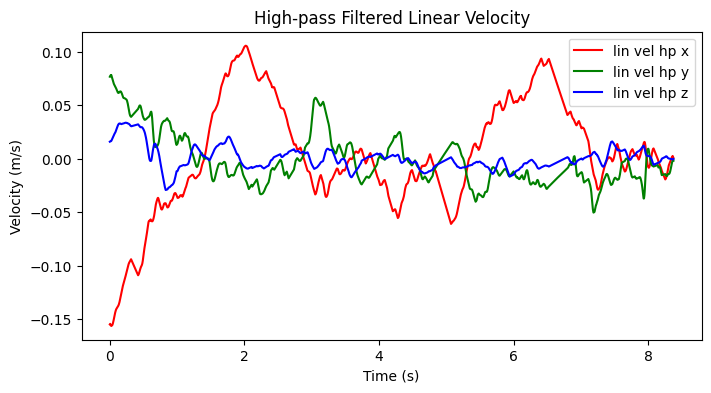

In [29]:
# high pass filter to linear velocity to remove drift
order = 2
filtCutOff = 0.1
b, a = butter(order, (2 * filtCutOff) / (1/sample_period), 'high')
lin_Vel_HP = filtfilt(b, a, lin_Vel, axis=0)
# plotting liear velocity after high pass filtering
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, lin_Vel_HP[:, 0], 'r', label='lin vel hp x')
ax.plot(time, lin_Vel_HP[:, 1], 'g', label='lin vel hp y')
ax.plot(time, lin_Vel_HP[:, 2], 'b', label='lin vel hp z')
ax.set_title('High-pass Filtered Linear Velocity')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Velocity (m/s)')
ax.legend()

plt.show()

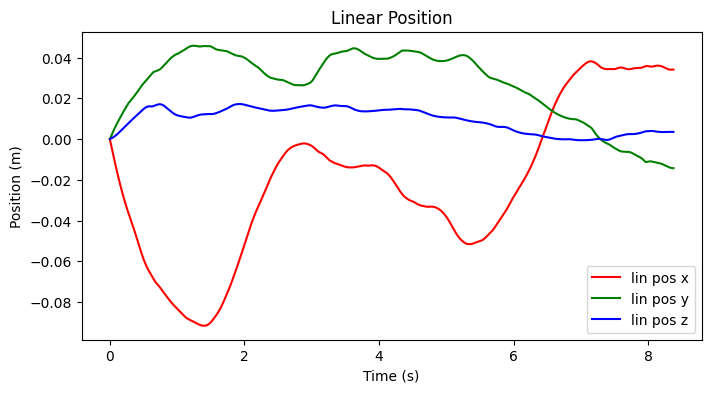

In [30]:
# calculate linear position (integrating velocity)
lin_Pos = np.zeros_like(lin_Vel_HP)
for t in range(1, len(time)):
    lin_Pos[t] = lin_Pos[t - 1] + lin_Vel_HP[t] * (time[t] - time[t - 1])
# plotting linear position
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, lin_Pos[:, 0], 'r', label='lin pos x')
ax.plot(time, lin_Pos[:, 1], 'g', label='lin pos y')
ax.plot(time, lin_Pos[:, 2], 'b', label='lin pos z')
ax.set_title('Linear Position')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Position (m)')
ax.legend()

plt.show()

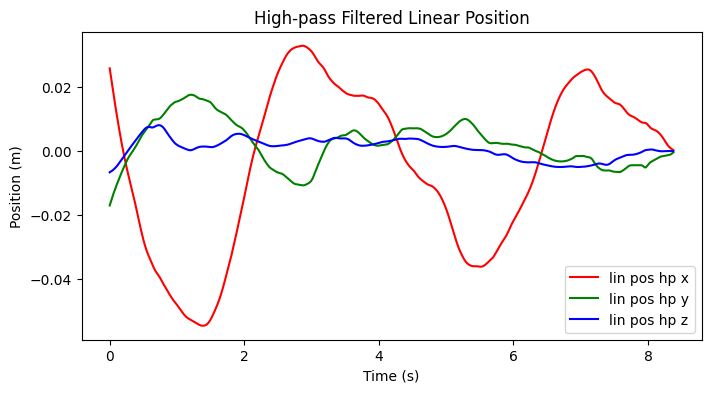

In [31]:
# High-pass filter linear position to remove drift
order = 2
filtCutOff = 0.1
b, a = butter(order, (2*filtCutOff)/(1/sample_period), 'high')
lin_Pos_HP = filtfilt(b, a, lin_Pos, axis=0)
# plotting linear position after high pass filtering
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, lin_Pos_HP[:, 0], 'r', label='lin pos hp x')
ax.plot(time, lin_Pos_HP[:, 1], 'g', label='lin pos hp y')
ax.plot(time, lin_Pos_HP[:, 2], 'b', label='lin pos hp z')
ax.set_title('High-pass Filtered Linear Position')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Position (m)')
ax.legend()

plt.show()

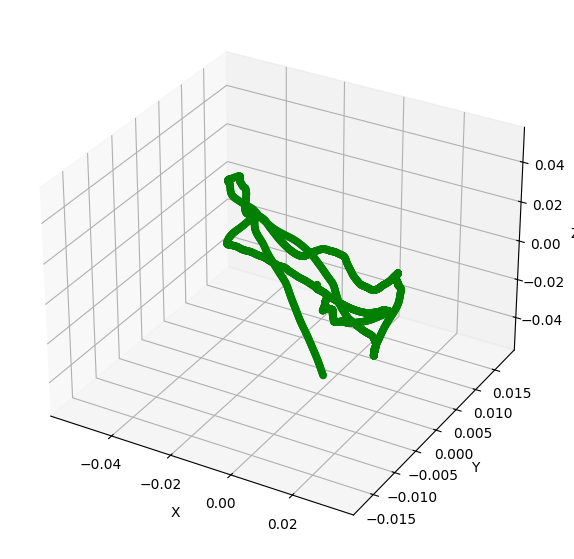

In [32]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(lin_Pos_HP[:, 0], lin_Pos_HP[:, 1], lin_Pos_HP[:, 2]*0, color="green")
# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [33]:
def _quaternConj(q):
    return np.array([q[0], -q[1], -q[2], -q[3]])

In [34]:
t1 = 1623
t2 = 2428
delta_quaternion = quaternion[t2] * _quaternConj(quaternion[t1])
delta_rotation_mat = quatern2rotMat(delta_quaternion)
delta_rotation_mat

array([[ 0.06825502,  0.00133983,  0.00230151],
       [ 0.00130005, -0.19418428, -0.45987103],
       [-0.00232422,  0.45987092, -0.19419091]])

In [35]:
np.rad2deg(quatern2euler(delta_quaternion.reshape((1, 4))))

array([[112.89300386,   0.13316791,   1.09117828]])

In [36]:
translation = lin_Pos_HP[t2] - lin_Pos_HP[t1]
translation

array([-3.42357107e-02,  7.43081252e-05, -5.45924541e-03])

In [ ]:
K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]])

In [ ]:
transformed_points = np.zeros_like(Kp1_np)
_Kp2_3D = []
for i in range(len(Kp1_3D)):
    _Kp2_3D.append(delta_rotation_mat @ Kp1_3D[i] + translation)

# _Kp2_pcd = o3d.geometry.PointCloud()
# _Kp2_pcd.points = o3d.utility.Vector3dVector(_Kp2_3D)
# _Kp2_pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
# # visualization
# o3d.visualization.draw_geometries([_Kp2_pcd])

In [ ]:
_Kp2 = []
for point in _Kp2_3D:
    pt = K @ point
    pt = pt / pt[-1]
    pt = pt[:-1]
    _Kp2.append(pt)

In [ ]:
_Kp2_img = np.ones((height, width, 3), dtype=np.uint8)*255
dot_size = 10
for point, _point in zip(Kp2_np, _Kp2):
    col, row = point
    col = int(col)
    row = int(row)
    _col, _row = _point
    _col = int(_col)
    _row = int(_row)
    _Kp2_img[row - dot_size // 2:row + dot_size // 2, col - dot_size // 2:col + dot_size // 2, :] = [0, 0, 255]
    if (0 < _col < width and 0 < _row < height):
        _Kp2_img[_row - dot_size // 2:_row + dot_size // 2, _col - dot_size // 2:_col + dot_size // 2, :] = [255, 0, 0]
plt.imshow(_Kp2_img)
plt.axis('off')
plt.show()

In [ ]:
Kp2_img = np.ones((height, width, 3), dtype=np.uint8)*255
_Kp2_img = np.ones((height, width, 3), dtype=np.uint8)*255
dot_size = 15
for point, _point in zip(Kp2_np, _Kp2) :
    col, row = point
    col = int(col)
    row = int(row)
    _col, _row = _point
    _col = int(_col)
    _row = int(_row)
    Kp2_img[row - dot_size // 2:row + dot_size // 2, col - dot_size // 2:col + dot_size // 2, :] = [0, 0, 255]
    if (0 < _col < width and 0 < _row < height):
        _Kp2_img[_row - dot_size // 2:_row + dot_size // 2, _col - dot_size // 2:_col + dot_size // 2, :] = [255, 0, 0]
plt.subplot(121)
plt.imshow(Kp2_img)
plt.axis('off')
plt.subplot(122)
plt.imshow(_Kp2_img)
plt.axis('off')
plt.show()

In [ ]:
def findHammingDistance(v1, v2):
    return np.sum(np.abs(v1 - v2))

In [ ]:
findHammingDistance(np.array([1, 0, 0]), np.array([0, 1, 1]))

In [ ]:
neighborhood_radius = 400
# Performing matches within neighborhood
matches = []
found_matches = 0
for i, (_p, _des) in enumerate(zip(_Kp2, des1)):
    nearby_original_Kp_idxs = np.where(
        np.linalg.norm(Kp2_np - _p, axis=1) < neighborhood_radius
    )[0]
    best_matched_index = -1
    if (len(nearby_original_Kp_idxs)):
        # match with nearby keypoints
        nearby_matches = []
        min_dis = 1500
        for j, desc2 in zip(nearby_original_Kp_idxs, des2[nearby_original_Kp_idxs]):
            hamming_dis = findHammingDistance(_des, desc2)
            if (hamming_dis < min_dis):
                min_dis = hamming_dis
                best_matched_index = j
    if (best_matched_index != -1):
        found_matches += 1
    matches.append(best_matched_index)

In [ ]:
found_matches

In [ ]:
# doing keypoint matching between kp2 and _kp2
matching_visual = np.zeros((height, width * 2, 3), dtype=np.uint8)
matching_visual[:, :width, :] = Kp2_img
matching_visual[:, width:, :] = _Kp2_img
points2 = []
_points2 = []
for i in range(Kp1_np.shape[0]):
    if (matches[i] != -1):
        pt2 = (int(Kp2_np[matches[i]][0]), int(Kp2_np[matches[i]][1]))
        _pt2 = (int(_Kp2[i][0] + width), int(_Kp2[i][1]))
        cv2.line(matching_visual, pt2, _pt2, (0, 255, 0), 2)
        pt2, _pt2 = list(pt2), list(_pt2)
        _pt2[0] = _pt2[0] - width
        points2.append(pt2)
        _points2.append(_pt2)
plt.imshow(matching_visual)
plt.axis('off')
plt.show()

In [ ]:
print(points2), print(_points2)

In [ ]:
# now doing keypoint matching between kp1 and kp2
matching_visual = np.zeros((height, width * 2, 3), dtype=np.uint8)
matching_visual[:, :width, :] = Kp1_img
matching_visual[:, width:, :] = Kp2_img
points1 = []
points2 = []
for i in range(Kp1_np.shape[0]):
    if (matches[i] != -1):
        pt1 = (int(Kp1_np[i][0]), int(Kp1_np[i][1]))
        pt2 = (int(Kp2_np[matches[i]][0] + width), int(Kp2_np[matches[i]][1]))
        cv2.line(matching_visual, pt1, pt2, (0, 255, 0), 2)
        pt1, pt2 = list(pt1), list(pt2)
        pt2[0] = pt2[0] - width
        points1.append(pt1)
        points2.append(pt2)
plt.imshow(matching_visual)
plt.axis('off')
plt.show()

In [ ]:
print(points1), print(points2)

In [ ]:
points1_np = np.array(points1)
points2_np = np.array(points2)

In [ ]:
# Applying RANSAC algorithm to get Essential matrix
E, mask = cv2.findEssentialMat(points1_np, points2_np, cameraMatrix=K, method=cv2.RANSAC, prob=0.999, threshold=1.0, mask=None)

In [ ]:
print(E)

In [ ]:
Proj_Mat1 = np.concatenate((K, np.zeros((3, 1))), axis=1)
Proj_Mat1

In [ ]:
def _form_transf(R, t):
    T = np.eye(4, dtype=np.float64)
    T[:3, :3] = R
    T[:3, 3] = t
    return T

def sum_z_cal_relative_scale(q1, q2, K, R, t):
    # Get the transformation matrix
    T = _form_transf(R, t)
    # Make the projection matrix
    '''
    Proj_Mat1 --> 3x4
    T --> 4x4
    Proj_Mat2 --> 3x4
    '''
    Proj_Mat2 = np.matmul(Proj_Mat1, T)

    # Triangulate the 3D points
    hom_Q1 = cv2.triangulatePoints(Proj_Mat1, Proj_Mat2, q1.T, q2.T)
    # Also seen from cam 2
    hom_Q2 = np.matmul(T, hom_Q1)

    # Un-homogenize
    uhom_Q1 = hom_Q1[:3, :] / (hom_Q1[3, :] + 1e-4)
    uhom_Q2 = hom_Q2[:3, :] / (hom_Q2[3, :] + 1e-4)

    # Find the number of points there has positive z coordinate in both cameras
    sum_of_pos_z_Q1 = sum(uhom_Q1[2, :] > 0)
    sum_of_pos_z_Q2 = sum(uhom_Q2[2, :] > 0)

    # Form point pairs and calculate the relative scale
    relative_scale = np.mean(np.linalg.norm(uhom_Q1.T[:-1] - uhom_Q1.T[1:], axis=-1) /
                                np.linalg.norm(uhom_Q2.T[:-1] - uhom_Q2.T[1:], axis=-1))
    return sum_of_pos_z_Q1 + sum_of_pos_z_Q2, relative_scale

def decom_Essential_Matrix(E, q1, q2, K):
    # Decompose the essential matrix
        R1, R2, t = cv2.decomposeEssentialMat(E)
        t = np.squeeze(t)
        # Make a list of the different possible pairs
        pairs = [[R1, t], [R1, -t], [R2, t], [R2, -t]]
        # Check which solution there is the right one
        z_sums = []
        relative_scales = []
        for R, t in pairs:
            z_sum, scale = sum_z_cal_relative_scale(q1, q2, K, R, t)
            z_sums.append(z_sum)
            relative_scales.append(scale)
        # Select the pair there has the most points with positive z coordinate
        right_pair_idx = np.argmax(z_sums)
        right_pair = pairs[right_pair_idx]
        relative_scale = relative_scales[right_pair_idx]
        R1, t = right_pair
        t = t * relative_scale
        return [R1, t]


In [ ]:
R, t = decom_Essential_Matrix(E, points1_np, points2_np, K)
print(R, t)